# PHYS3009: TeV Astronomy Project

Name: 

Student No.:

total marks: 41

In this project you will do yourself the data analysis of the object 
RX J1713.7-3946. You mainly need to copy and paste code from the Crab Nebula notebook which we have discussed in the lecture, and make the necessary changes for the new source. You will be provided with example output so that you can check your results. Please put your code in the cells starting with 

```
# your code here
```

You do not need to edit any other cells. If you want to add additional ouput, or test some things you can create new cells for that.

## Import Modules and Download Data

In [ ]:
%matplotlib inline
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
import matplotlib.pyplot as plt
import numpy as np
from regions import CircleSkyRegion
import scipy.stats

import os

In [ ]:
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.makers import  (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
)
from gammapy.estimators import (
    ExcessMapEstimator,
    FluxPointsEstimator,
)
from gammapy.maps import Map, WcsNDMap, MapAxis
from gammapy.datasets import MapDatasetOnOff
from gammapy.data import EventList
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [ ]:
path = 'gammapy-tutorials/datasets/hess-dl3-dr1'

if not os.path.exists(os.path.join(path, 'hdu-index.fits.gz')):
    os.system('gammapy download tutorials --release 0.17')
    
if not os.path.exists(os.path.join(path, 'hdu-index.fits.gz')):
    raise Exception("gammapy-data repository not found!")
else:
    print("Great your setup is correct!")

## Create Data Set

You can find the position of RX J1713.7-3946 on TeVCat: http://tevcat.uchicago.edu/?mode=1&showsrc=84
Here are the coordinates:

In [ ]:
source_pos = SkyCoord("17:13:33.6", "-39:45:36", unit=(u.hourangle, u.deg), frame='icrs')

We create a final_results dictionary to save all our results and we create an AnalysisConfig object.

In [ ]:
final_results= {}
config = AnalysisConfig()

## Exercise  ##

Fill the config object with the necessay information to allow for a cone search.

In [ ]:
# your code here
# ~7 lines of code


In [ ]:
print (config.observations)

Expected output:

`
datastore=PosixPath('gammapy-tutorials/datasets/hess-dl3-dr1') obs_ids=[] obs_file=None obs_cone=SpatialCircleConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 258.39 deg>, lat=<Angle -39.76 deg>, radius=<Angle 2.5 deg>) obs_time=TimeRangeConfig(start=None, stop=None)
`

Output produced: **[2 marks]**

You need a few more settings. Execute the next cell.

In [ ]:
config.datasets.type = "3d"
config.datasets.geom.wcs.skydir = {
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "frame": "icrs",
} 
config.datasets.geom.wcs.fov = {"width": "5 deg", "height": "5 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# The FoV radius to use for cutouts
config.datasets.geom.selection.offset_max = 5 * u.deg

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.5 TeV"
config.datasets.geom.axes.energy.max = "5 TeV"
config.datasets.geom.axes.energy.nbins = 3

# We need to extract the ring for each observation separately, hence, no stacking at this stage
config.datasets.stack = False

In [ ]:
analysis = Analysis(config)
# for this specific case,w e do not need fine bins in true energy
analysis.config.datasets.geom.axes.energy_true = (
    analysis.config.datasets.geom.axes.energy
)

## Exercise ##

Now you need to get the observations. How many runs did you find?

In [ ]:
# your code here
# 2 line of code


Expected output:

`
found 15 runs: ['20898', '20899', '20900', '20421', '20326', '20327', '20422', '20517', '20518', '20519', '20396', '20397', '20521', '20349', '20350']
`

Output produced: **[1 mark]**

The centre of run 20900 is inside the source. This means that no reflected background region can be found and the spectrum generation will fail. We will remove the run:

In [ ]:
analysis.observations.pop('20900')

Now we get the datasets.

In [ ]:
analysis.get_datasets()

Expected output:

`
Creating geometry.
Creating datasets.
No background maker set for 3d analysis. Check configuration.
Processing observation 20898
Processing observation 20899
Processing observation 20421
Processing observation 20326
Processing observation 20327
Processing observation 20422
Processing observation 20517
Processing observation 20518
Processing observation 20519
Processing observation 20396
Processing observation 20397
Processing observation 20521
Processing observation 20349
Processing observation 20350
`

Make sure that run 20900 is not in the output above.


## Sky Maps
Now you need to apply the RingBackground and subtract the background noise from the image. The next cell creates the geometry of the image to be produced.

In [ ]:
geom = analysis.datasets[0].counts.geom
energy_axis = analysis.datasets[0].counts.geom.axes['energy']
geom_image = geom.to_image()

## Exercise ##

First you have to define an exclusion region. The region should be a circular region centred on the source. You will need to make a guess on the size of the region. You can start with the value we used for the Crab Nebula. You might get back here and adjust at a later stage. Your region should be called "regions".  **[3 marks]**

In [ ]:
# your code here
# 1 line of code

regions = ...

In [ ]:
exclusion_mask = Map.from_geom(geom_image)
exclusion_mask.data = geom_image.region_mask([regions], inside=False)
exclusion_mask.sum_over_axes().plot();

Expected output:
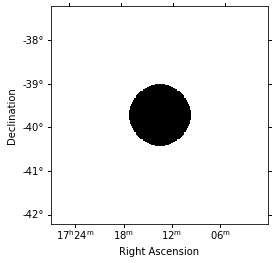

## Exercise ##

Copy the code to create the RingBackgroundMaker and to create the stacked_on_off data set. Your code must produce a data set called "stacked_on_off". 

**[3 marks]**

In [ ]:
# your code here
# ~10 lines of code


## Exercise ##

Create an excess map from the stacked_on_off data set. You should make use of stacked_on_off.counts, stacked_on_off.counts_off and stacked_on_off.alpha. The excess map should be called "excess_map". 

**[3 marks]**

In [ ]:
# your code here
# 1 - 4 lines of code

excess_map = ...

The excess map has 10 bins in energy. Let's sum that all up.

In [ ]:
excess_map = excess_map.sum_over_axes()

## Exercise ##

The following cell plots your excess map and indicates your exclusion region:

In [ ]:
excess_map.smooth(width=0.05 * u.deg, kernel="gauss").plot(add_cbar = True, stretch='linear')
regions.to_pixel(excess_map.geom.wcs).plot(color = 'blue')

Expected output:
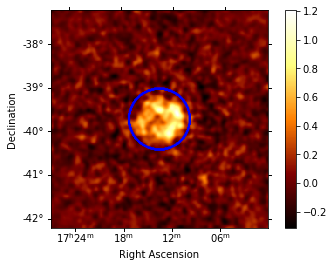

Output produced and exclusion region is larger then emission: **[2 marks]**

Your exclusion region (the blue circle) must be larger than the source in your image. If this is not the case you should go back, adjust the exclusion region and re-run the code again. When you are happy with your outcome you can proceed to the next cell to create the excess and significance map. You can adjust the estimator size in the first line to change the oversampling of the map.

The next cell takes about 10min. Please be patient.

In [ ]:
%%time

estimator = ExcessMapEstimator(0.1 * u.deg)

lima_maps = estimator.run(stacked_on_off)

full_significance_map = lima_maps["sqrt_ts"]
full_excess_map = lima_maps["excess"]

significance_map = full_significance_map.get_image_by_idx((0,))
excess_map = full_excess_map.get_image_by_idx((0,))

# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
ax2 = plt.subplot(222, projection=excess_map.geom.wcs)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)

Expected output:
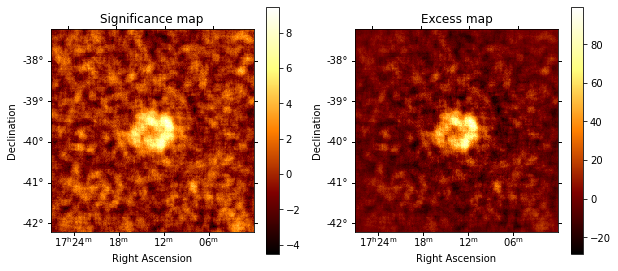

You clearly see the shell of the supernova remnant in your maps. The significance exceeds 5 sigma, so you have a clear detection. If you see only one blob of emission then your estimator size is too large.

Let's keep the maps for the end.

In [ ]:
final_results['excess map'] = excess_map.copy()
final_results['significance map'] = significance_map.copy()

# Reflected Regions Background
Now you will find background control regions for your source. Start with finding the regions, estimating the background and calculating the significance of the source.

## Exercise ##

Define your on region. It should be called "on_region". Keep the centre as before, and adjust the radius such that it includes the entire source.

In [ ]:
# your code here
# 1 line of code

on_region = ...

Check on the following map that your on-source region (white contour) includes the entire source.

In [ ]:
final_results['significance map'].plot(add_cbar = True)
on_region.to_pixel(final_results['significance map'].geom.wcs).plot(color = 'white')

Expected output:
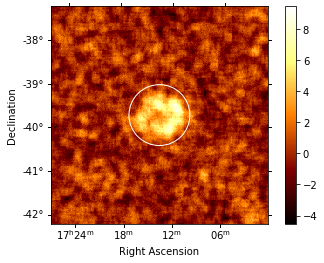

Output produced an on regions contains the emission: **[2 marks]**

Let's define the binning for the energy axes:

In [ ]:
e_reco = MapAxis.from_energy_bounds(0.2, 20, 10, unit="TeV", name="energy")
e_true = MapAxis.from_energy_bounds(0.05, 100, 50, unit="TeV", name="energy_true"
)

dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)

## Exercise ##

Now copy the code to create the SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker and SafeMaskMaker. Make sure that they are called dataset_maker, bkg_maker and safe_mask_masker. You can use the exclusion_mask defined above. **[2 marks]**

In [ ]:
# your code here
# ~5 lines of code


## Exercise ##

Next copy the code which creates and empty Datasets and loops over all the observations. **[2 marks]**

In [ ]:
# your code here
# ~9 lines of code



You might get an error here. If the last line above reads

`
ValueError: ndim mismatch
`

then you have added an exclusion region which excludes the source we are interested in. Make the exclusion region slightly smaller and try again.

Let's have a look at the locations of the background regions.

In [ ]:
box = Map.create(binsz=0.01, width=(10, 6), skydir=source_pos, frame='icrs')
_, ax, _ = box.plot()
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

You might get an error here. Check the last line of the output above. If it reads

`
AttributeError: 'NoneType' object has no attribute 'plot_region'
`

then your on_region might be too large (do not exceed 0.65deg) or you forgot to remove run 20900 (see at the beginning of the notebook).

Expected output:
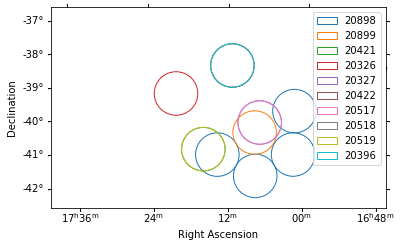

You see that there are much less control regions than in our Crab Nebula example. The reason is the large size of our source and that the observations have much smaller offsets. Most runs have only one single off-source region. You do not see all regions because some are on top of another.

In [ ]:
info_table = datasets.info_table(cumulative=True)

The last line of the info_table contains the overall result.

## Exercise ##

The column "sqrt_ts" is your significance value. Is your result significant? If it is not you need to check your on_region again. It might be too small or too big. If the result is significant then fill the next cell to save the numbers for later use.

**[ 2 marks]**

In [ ]:
# your code here
# 2 lines of code

final_results['excess'] = ...
final_results['significance'] = ...

# Spectrum Fit
Now you will fit the spectrum. Try two different models, a straight power law and a power law with exponential cut-off. Compare the likelihoods of the two fits and decide which model to keep.

We will use the stacked data set:

In [ ]:
dataset_stacked = Datasets(datasets).stack_reduce()

## Exercise ##

Now create a spectral model for a power law. Then you create a SkyModel named model. Name the model 'J1713_PL'.

In [ ]:
# your code here
# ~4 lines of code

model =  ...

In [ ]:
print(model)

Expected output:

```
SkyModel

  Name                      : J1713_PL
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : None
  Temporal model type       : None
  Parameters:
    index                   :   2.000              
    amplitude               :   2.00e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
```

Output produced: **[2 marks]**

## Exercise ##

Now assign the model to the dataset_stacked, create a Fit object and run the fit. The result of the run should be named result_stacked. **[3 marks]**

In [ ]:
# your code here
# 3 lines of code


## Exercise ##

Did your fit terminate succesfully?

In [ ]:
print(result_stacked)

Expected output:

```
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 41
	total stat : 86.17
```
    
Your numbers may be different. It is important that the optimization terminated succesfully. **[1 mark]**

Let's copy the model and the likelihood of the fit for later use.

In [ ]:
model_best_PL = model.copy(name='J1713_PL')
L_PL = result_stacked.total_stat

In [ ]:
model_best_PL.parameters.to_table()

Expected output:

|name	|value	|unit	|min	|max	|frozen	|error|
|---|---|---|---|---|---|---|
|index	|2.079e+00|		|nan	|nan	|False	|4.110e-02|
|amplitude	|1.603e-11	|cm-2 s-1 TeV-1	|nan	|nan	|False|	9.001e-13|
|reference	|1.000e+00	|TeV	|nan	|nan	|True	|0.000e+00|

Your numbers may be different. If your amplitude is much lower than this your source region might be too small.

## Exercise ##

Make a plot of the spectrum and the residuals.

In [ ]:
# your code here
# ~2 lines of code


Expected output:
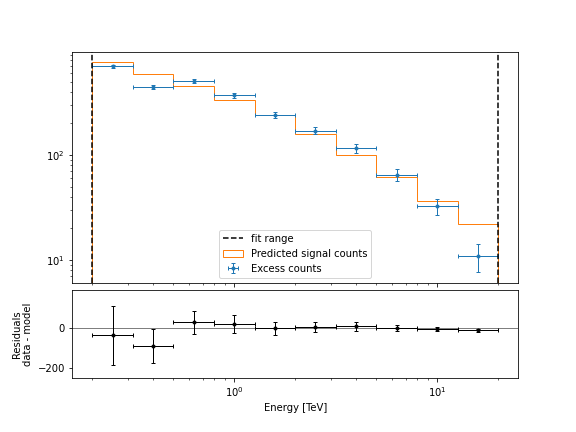

Output produced: **[2 marks]**

## Exercise ##

Now you should test a power law with exponential cut-off. Name the model "J1713_ExpPL". Create a new model. You can use the fit results from above as starting parameters for your new model. Assign the model to the data set and perform the fit. Copy the model into model_best_expPL and save the likelihood in L_expPL. Print the result of the fit run and make sure that the optimisation terminated succesfully. You may get an error during the fit. In this case try to adjust the starting parameters of the fit. **[6 marks]**

In [ ]:
# your code here
# ~10 lines of code


In [ ]:
plt.figure(figsize=(8, 6))
ax_spectrum, ax_residual = dataset_stacked.plot_fit()

In [ ]:
print(model_best_expPL.parameters.to_table())
print('\nlikelihood = ', L_expPL)

Expected output:

```
   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
    index 1.8990e+00                nan nan  False 1.014e-01
amplitude 1.9043e-11 cm-2 s-1 TeV-1 nan nan  False 1.482e-12
reference 1.0000e+00            TeV nan nan   True 0.000e+00
  lambda_ 8.3630e-02          TeV-1 nan nan  False 3.935e-02
    alpha 1.0000e+00                nan nan   True 0.000e+00

likelihood =  4.138196147022541
```

Your numbers may be slightly different.

## Exercise ##

Now compare the likelihoods of your fit using Wilk's theorem and decide whether you keep the null hypothesis (the straight power law) or if you accept the alternative model (with a cut-off). You should accept the alternative model when the probability is lower then $2.7 \times 10^{-3}$. **[2 marks]**

In [ ]:
# your code here
# ~4 lines of code


## Exercise ##

We will keep your accepted model. Copy your best model into bestmodel in the next cell.

In [ ]:
# your code here
# 1 line of code

bestmodel = ...

In [ ]:
print(bestmodel)

We will keep this model for later use.

Correct model identified: **[1 mark]**

In [ ]:
dataset_stacked.models = bestmodel
final_results['fit parameters'] = bestmodel.parameters.to_table()
final_results['model type'] = bestmodel.spectral_model.tag

# Spectrum Points
Finally we will create the spectrum points for the best fit model.

In [ ]:
e_min, e_max = 0.5, 50
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 11) * u.TeV

In [ ]:
fpe = FluxPointsEstimator(energy_edges=e_edges, source=bestmodel.name)
flux_points = fpe.run(datasets=dataset_stacked)

In [ ]:
flux_points.table_formatted

In [ ]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=bestmodel
)

plt.figure(figsize=(8, 6))
flux_points_dataset.plot_fit()

If you are happy with your result execute the next cells to save everything for later use.

In [ ]:
final_fluxpoints = flux_points.table_formatted['e_ref', 'e_min', 'e_max', 'ref_dnde', 'dnde_err','counts']
final_results['flux points'] = final_fluxpoints

# Summary
This is it. You have done an analysis of the data recorded with H.E.S.S. on the supernova remnant RX J1713.7-3946. Let's summarise all results.

In [ ]:
print('You have detected an excess of {:4.1f} gamma rays with a statistical significance of {:3.1f} sigma.'.format(final_results['excess'], final_results['significance']))
print('The spectrum is best described by a {:s}.'.format(final_results['model type'][0]))
print('The best fit parameters are:\n', final_results['fit parameters'])
print('The spectral data points are:\n', final_results['flux points'])

plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=final_results['significance map'].geom.wcs)
ax2 = plt.subplot(222, projection=final_results['excess map'].geom.wcs)

ax1.set_title("Significance map")
final_results['significance map'].plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
final_results['excess map'].plot(ax=ax2, add_cbar=True)

## Exercise ##

All elements in the final results are filled.    **[1 mark]**

# Sanity Check
Before you submit your work you should make a few checks that everything works fine.

1. Save your notebook as a PDF (File->Download As->PDF). This document will help you debugging in the next step.
1. Restart the kernel and rerun the entire notebook (Kernel->Restart & Run All). This will delete all variables (but not your code) and rerun the notebook in one go. If this does not go through the end (i.e. you do not see the output of the next cell) then you have to fix it. You will see at which cell the run stopped. A common mistake is using a variable that is defined only at a later stage.
1. You think you fixed everything? Redo step 2 (Kernel->Restart & Run All)

In [ ]:
print('a\bYa\boa\bua\b a\baa\bra\bea\b a\bra\bea\baa\bda\bya\b a\bta\boa\b a\bsa\bua\bba\bma\bia\bta\b.a\b')

Do you see the output of the last cell without explicitly running it? Then the notebook goes through with one kernel restart. You can proceed to submission.
You do not see the output? Go back to step 2 above.

## Exercise ##

The jupyter notebook goes through all cells with one Kernel Restart & Run all.    **[1 mark]**

# Submission
You have to download and submit 3 files.
- PDF file. File->Download As->PDF. Save this file on your disk.
- **Jupyter notebook**. File->Download As->Notebook (.ipynb). Save this file on your disk.
- Spectral data points. Go to the Home Page of your jupyter notebooks. It is in a different tab or window of your browser. Find the file `J1731.dat` and save it to your disk.

Congratulations. You have succesfully completed your TeV Astronomy project.